<h2 style="color:red;text-align:center;font-weight:bold;">AeroStream Analytics</h2>

AeroStream Analytics est un système intelligent de classification automatique des avis clients des compagnies aériennes. Il analyse en temps réel le sentiment des utilisateurs afin de mesurer leur niveau de satisfaction et fournir des indicateurs clés de performance.

**Objectifs :**

Développer un système de classification automatique des avis clients en temps réel, Le
système devra permettre de:

- Collecter et prétraiter les avis clients,

- Analyser automatiquement le sentiment et la satisfaction,

- Générer des indicateurs de performance par compagnie aérienne,

- Visualiser les résultats via un tableau de bord interactif.

![Python](https://img.shields.io/badge/Python-3.9%2B-blue)
![Airflow](https://img.shields.io/badge/Apache%20Airflow-Orchestration-green)
![Streamlit](https://img.shields.io/badge/Streamlit-Dashboard-red)
![ChromaDB](https://img.shields.io/badge/ChromaDB-Vector%20Store-orange)

<br>

<h3 style="color:green;font-weight:bold;">Entraînement et Evaluation :</h3>

<h4 style="color:orange;font-weight:bold;">1. Charger les Données :</h4>

In [13]:
import chromadb

client = chromadb.PersistentClient(path="../chroma_db")

def getting_collection(client, name) :
    collection = client.get_collection(name=name)
    data = collection.get(include=['embeddings','metadatas'])
    return collection, data

train_collection, train_data = getting_collection(client, "train")

test_collection, test_data = getting_collection(client, "test")

<h4 style="color:orange;font-weight:bold;">2. Séparer les Données d'Entraînement et de Test :</h4>

<h5 style="font-weight:bold;">2.1. Séparer X_train, y_train, X_test, y_test :</h5>

In [14]:
import numpy as np

def split_data(data, name) :
    X = np.array(data['embeddings'])
    y = np.array([d['sentiment'] for d in data['metadatas']])
    
    print(f"- Dimensions X_{name} : {X.shape}")
    print(f"- Dimensions y_{name} : {y.shape}")
    
    return X, y

X_train, y_train = split_data(train_data, "train")

- Dimensions X_train : (11376, 768)
- Dimensions y_train : (11376,)


In [15]:
X_test, y_test = split_data(test_data, "test")

- Dimensions X_test : (2844, 768)
- Dimensions y_test : (2844,)


<h5 style="font-weight:bold;">2.2. Equilibrer les Données d'Entraînement :</h5>

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"\n- Distribution avant SMOTE (Train) : {Counter(y_train)}")
print(f"\n- Nombre Total des Echantillons avant SMOTE (Train) : {len(y_train)}")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"\n- Distribution après SMOTE (Train) : {Counter(y_train_res)}")
print(f"\n- Nombre Total des Echantillons après SMOTE (Train) : {len(y_train_res)}")


- Distribution avant SMOTE (Train) : Counter({np.str_('negative'): 7220, np.str_('neutral'): 2374, np.str_('positive'): 1782})

- Nombre Total des Echantillons avant SMOTE (Train) : 11376

- Distribution après SMOTE (Train) : Counter({np.str_('negative'): 7220, np.str_('positive'): 7220, np.str_('neutral'): 7220})

- Nombre Total des Echantillons après SMOTE (Train) : 21660


<h4 style="color:orange;font-weight:bold;">3. Encodage des Sentiments :</h4>

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\n- Mapping des classes : {mapping}")

print(f"\n- Exemple y_train (brut)    : {y_train_res[:5]}")
print(f"\n- Exemple y_train (encoded) : {y_train_encoded[:5]}")

print(f"\n- Dimensions y_train_encoded : {y_train_encoded.shape}")
print(f"\n- Dimensions y_test_encoded  : {y_test_encoded.shape}")


- Mapping des classes : {np.str_('negative'): np.int64(0), np.str_('neutral'): np.int64(1), np.str_('positive'): np.int64(2)}

- Exemple y_train (brut)    : ['negative' 'positive' 'negative' 'negative' 'negative']

- Exemple y_train (encoded) : [0 2 0 0 0]

- Dimensions y_train_encoded : (11376,)

- Dimensions y_test_encoded  : (2844,)


<h4 style="color:orange;font-weight:bold;">4. Entraînement et Evaluation des Modèles ML :</h4>

<h5 style="font-weight:bold;">4.1. Fonctions Utiles :</h5>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from utils.functions import plot_learning_curve, plot_multiclass_roc, plot_confusion_matrix
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


# Fonction d'Entraînement du Modèle
def train_model(model, X_train, y_train, model_name) :
    print(f"- Entraînement du Modèle {model_name}")
    model.fit(X_train, y_train)
    print("- Fin d'Entraînement !")
    return model



# Fonction d'Evaluation du Modèle
def evaluate_model(model, model_name, X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train_res, n_classes):
    print("="*80)
    print(f"Evaluation du Modèle {model_name}")
    print("="*80)
    
    y_pred_train = model.predict(X_train_res)
    y_pred_test = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    acc_train = accuracy_score(y_train_encoded, y_pred_train)
    acc_test = accuracy_score(y_test_encoded, y_pred_test)
    
    print(f"- Accuracy Train : {acc_train:.4f}")
    print(f"- Accuracy Test : {acc_test:.4f}")
    
    print(f"- Gap Overfiting : {acc_train - acc_test}")
    
    auc_score = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    print(f"\n- ROC AUC (OvR) : {auc_score:.4f}")
    
    print("\n- Rapport de Classification :")
    print(classification_report(y_test_encoded, y_pred_test, target_names=target_names))
    
    print("\n- Génération de la Matrice de Confusion...")
    plot_confusion_matrix(y_test_encoded, y_pred_test, model_name, target_names)
    
    print("\n- Génération de la Courbe ROC...")
    plot_multiclass_roc(y_test_bin, y_prob, model_name, n_classes, target_names)
    
    print(f"\n- Génération de la Courbe d'Apprentissage pour {model_name}...")
    plot_learning_curve(model, model_name, X_train_res, y_train_encoded, cv=3)
    


# Fonction de Sauvegarde des Modèles
def save_model(model, model_name, category, type):
    print(f"- Sauvegarde du Modèle {model_name}")
    
    folder = f"../models/{category}"
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    path = f"{folder}/{model_name.lower()}_{type}.pkl"
    
    joblib.dump(model, path)
    print(f"- Modèle Sauvegardé avec Succès sous : {path}")



target_names = ["negative", "neutral", "positive"]
n_classes = len(target_names)
y_test_bin = label_binarize(y_test_encoded, classes=range(n_classes))

<br>
<h5 style="font-weight:bold;">4.2. LogisticRegrassion :</h5>

<h3 style="color:yellow;text-align:center;font-weight:bold">Sans Grid-Search</h3>

In [19]:
lr_model = LogisticRegression(
    C=1, 
    solver='saga', 
    max_iter=1000, 
    random_state=42,
    class_weight='balanced'
)

lr_model = train_model(lr_model, X_train, y_train_encoded, "Logistic Regression")

- Entraînement du Modèle Logistic Regression
- Fin d'Entraînement !


Evaluation du Modèle Logistic Regression
- Accuracy Train : 0.8320
- Accuracy Test : 0.8073
- Gap Overfiting : 0.02470112517580869

- ROC AUC (OvR) : 0.9289

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.94      0.82      0.88      1805
     neutral       0.59      0.75      0.66       593
    positive       0.72      0.82      0.76       446

    accuracy                           0.81      2844
   macro avg       0.75      0.80      0.77      2844
weighted avg       0.83      0.81      0.81      2844


- Génération de la Matrice de Confusion...


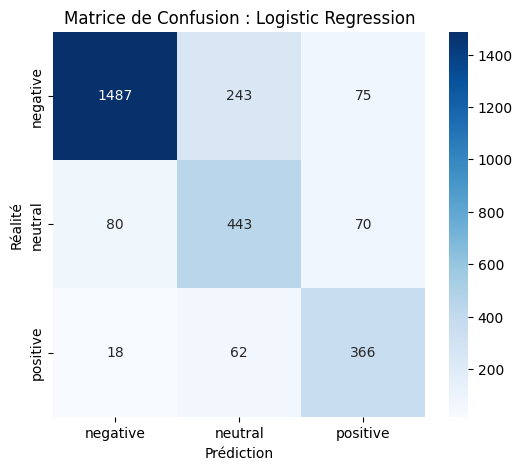


- Génération de la Courbe ROC...


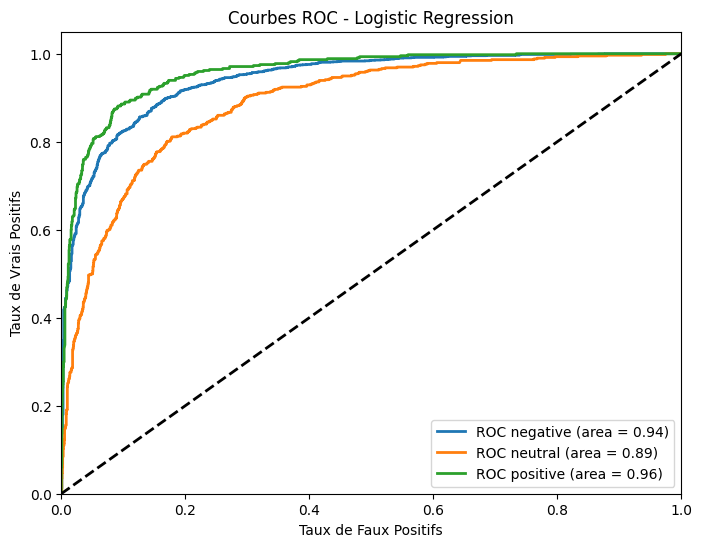


- Génération de la Courbe d'Apprentissage pour Logistic Regression...


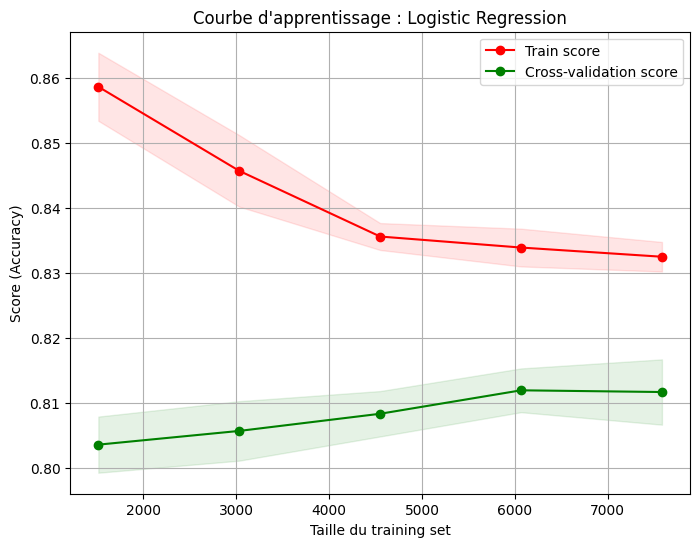

In [20]:
evaluate_model(lr_model, "Logistic Regression", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train, n_classes)

In [21]:
save_model(lr_model, "Logistic_Regression", "ML", "brut")

- Sauvegarde du Modèle Logistic_Regression
- Modèle Sauvegardé avec Succès sous : ../models/ML/logistic_regression_brut.pkl


<br>

<h3 style="color:yellow;text-align:center;font-weight:bold">Avec Grid-Search</h3>

In [22]:
from sklearn.model_selection import GridSearchCV

lr_grid_model = LogisticRegression(solver='saga', max_iter=2000, random_state=42)

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2', 'l1'],
    'class_weight': [None, 'balanced']
}

grid_search_lr = GridSearchCV(
    estimator=lr_grid_model,
    param_grid=lr_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

lr_grid_model = train_model(grid_search_lr, X_train, y_train_encoded, "Logistic Regression Tuned")

best_lr_model = lr_grid_model.best_estimator_

- Entraînement du Modèle Logistic Regression Tuned
- Fin d'Entraînement !


In [23]:
print(f"Meilleurs paramètres trouvés : {lr_grid_model.best_params_}")

Meilleurs paramètres trouvés : {'C': 10, 'class_weight': None, 'penalty': 'l2'}


Evaluation du Modèle Logistic Regression Tuned
- Accuracy Train : 0.8726
- Accuracy Test : 0.8326
- Gap Overfiting : 0.03999648382559773

- ROC AUC (OvR) : 0.9339

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.89      0.92      0.90      1805
     neutral       0.67      0.63      0.65       593
    positive       0.80      0.75      0.78       446

    accuracy                           0.83      2844
   macro avg       0.79      0.77      0.78      2844
weighted avg       0.83      0.83      0.83      2844


- Génération de la Matrice de Confusion...


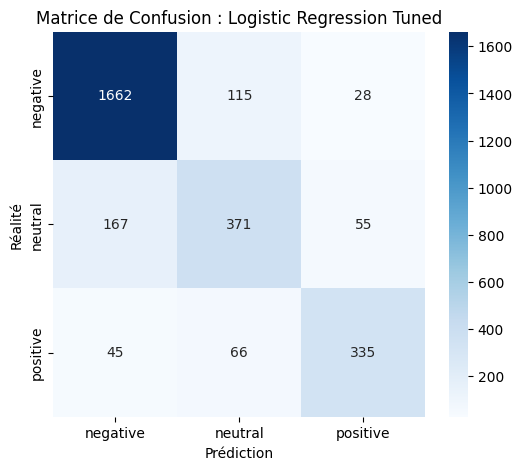


- Génération de la Courbe ROC...


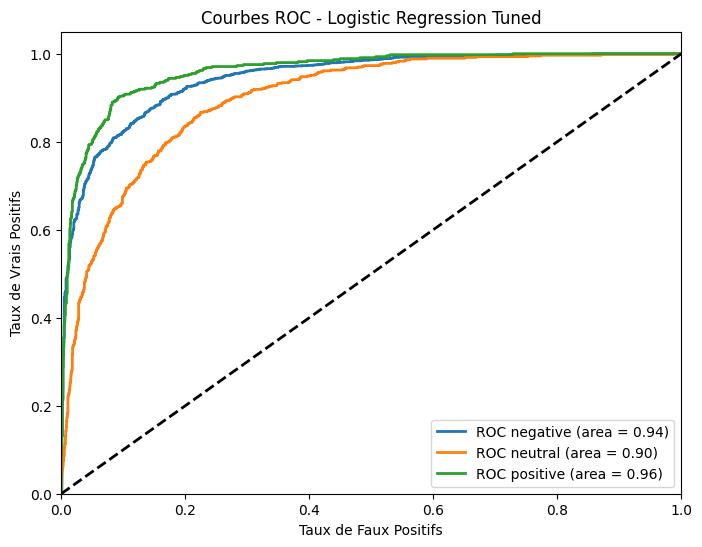


- Génération de la Courbe d'Apprentissage pour Logistic Regression Tuned...


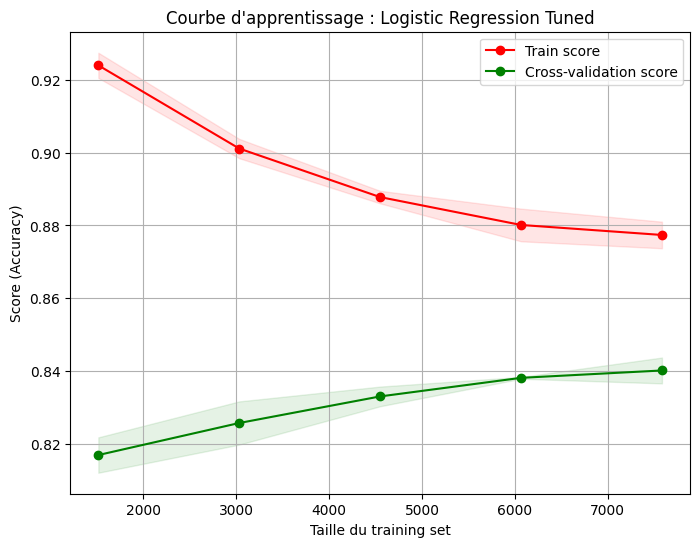

In [24]:
evaluate_model(best_lr_model, "Logistic Regression Tuned", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train, n_classes)

In [25]:
save_model(best_lr_model, "Logistic_Regression", "ML", "tuned")

- Sauvegarde du Modèle Logistic_Regression
- Modèle Sauvegardé avec Succès sous : ../models/ML/logistic_regression_tuned.pkl


<br>

<h5 style="font-weight:bold;">4.3. Linear SVC :</h5>

<h3 style="color:yellow;text-align:center;font-weight:bold">Sans Grid-Search</h3>

In [26]:
svc_model = CalibratedClassifierCV(
    estimator=LinearSVC(C=1, dual=False, max_iter=2000, random_state=42, class_weight='balanced'),
    method='sigmoid',
)

svc_model = train_model(svc_model, X_train, y_train_encoded, "Linear SVC")

- Entraînement du Modèle Linear SVC
- Fin d'Entraînement !


Evaluation du Modèle Linear SVC
- Accuracy Train : 0.8666
- Accuracy Test : 0.8347
- Gap Overfiting : 0.03182137834036569

- ROC AUC (OvR) : 0.9341

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.89      0.93      0.91      1805
     neutral       0.68      0.62      0.65       593
    positive       0.81      0.74      0.77       446

    accuracy                           0.83      2844
   macro avg       0.79      0.76      0.78      2844
weighted avg       0.83      0.83      0.83      2844


- Génération de la Matrice de Confusion...


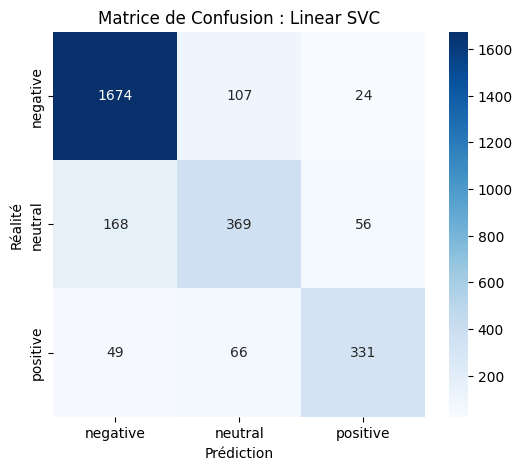


- Génération de la Courbe ROC...


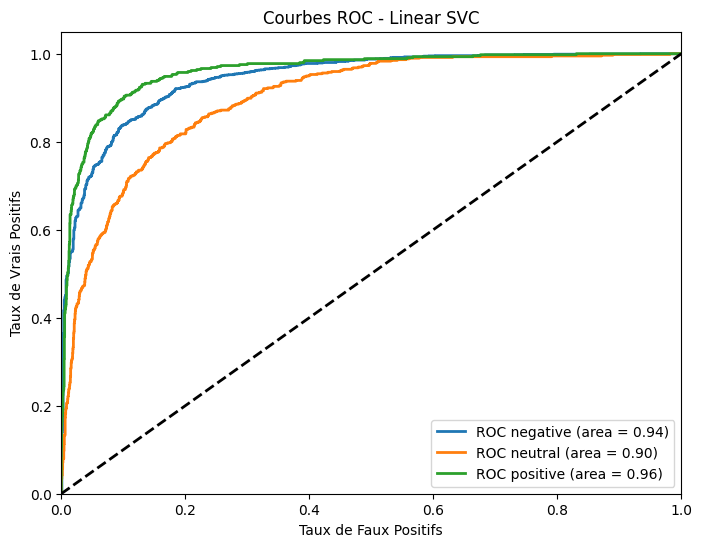


- Génération de la Courbe d'Apprentissage pour Linear SVC...


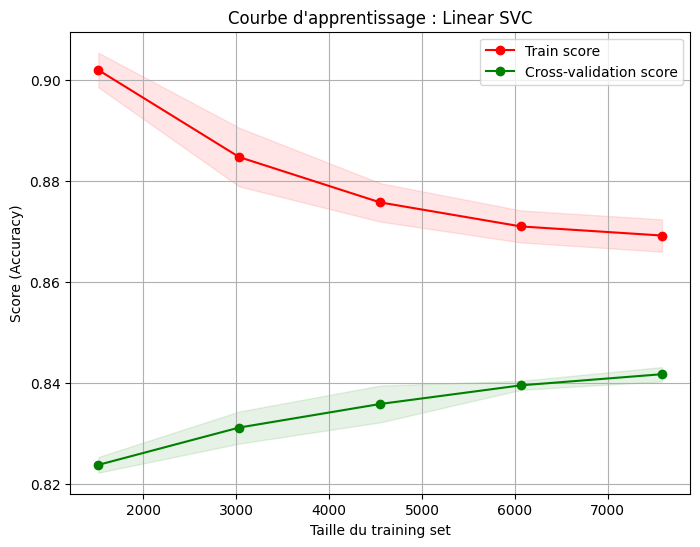

In [27]:
evaluate_model(svc_model, "Linear SVC", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train, n_classes)

In [28]:
save_model(svc_model, "Linear_SVC", "ML", "brut")

- Sauvegarde du Modèle Linear_SVC
- Modèle Sauvegardé avec Succès sous : ../models/ML/linear_svc_brut.pkl


<br>

<h3 style="color:yellow;text-align:center;font-weight:bold">Avec Grid-Search</h3>

In [29]:
svc_grid_model = CalibratedClassifierCV(estimator=LinearSVC(dual=False, max_iter=2000, random_state=42), method='sigmoid')

svc_param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__class_weight': [None, 'balanced']
}

grid_search_svc = GridSearchCV(
    estimator=svc_grid_model,
    param_grid=svc_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

svc_grid_model = train_model(grid_search_svc, X_train, y_train_encoded, "Linear SVC Tuned")

best_svc_model = svc_grid_model.best_estimator_

print(f"\n- Meilleurs Paramètres Trouvés : {svc_grid_model.best_params_}")

- Entraînement du Modèle Linear SVC Tuned
- Fin d'Entraînement !

- Meilleurs Paramètres Trouvés : {'estimator__C': 1, 'estimator__class_weight': None}


Evaluation du Modèle Linear SVC Tuned
- Accuracy Train : 0.8667
- Accuracy Test : 0.8368
- Gap Overfiting : 0.029887482419128086

- ROC AUC (OvR) : 0.9338

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.88      0.93      0.91      1805
     neutral       0.70      0.62      0.65       593
    positive       0.80      0.75      0.78       446

    accuracy                           0.84      2844
   macro avg       0.79      0.77      0.78      2844
weighted avg       0.83      0.84      0.83      2844


- Génération de la Matrice de Confusion...


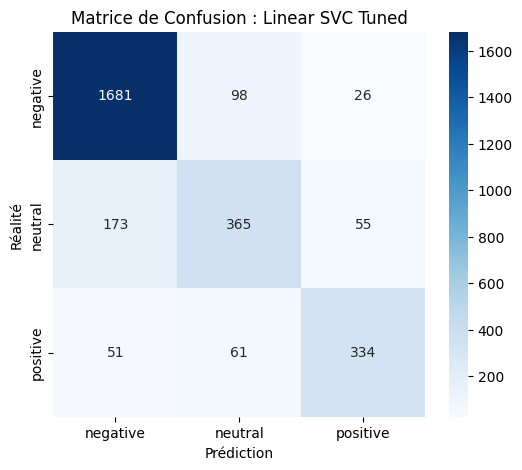


- Génération de la Courbe ROC...


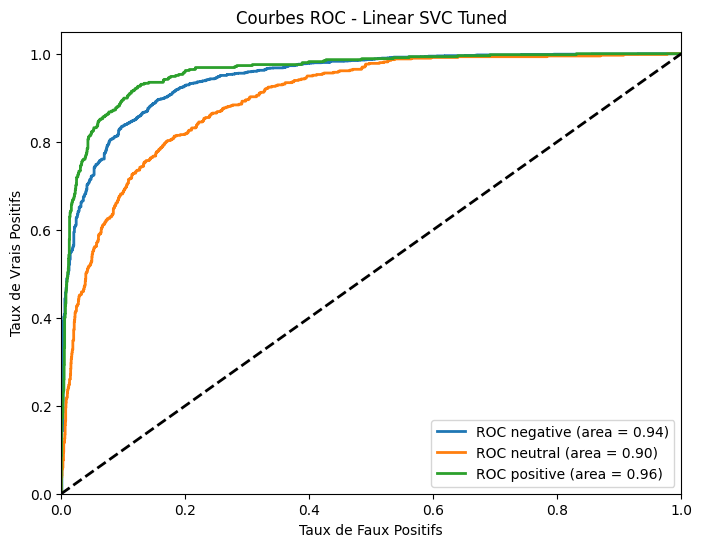


- Génération de la Courbe d'Apprentissage pour Linear SVC Tuned...


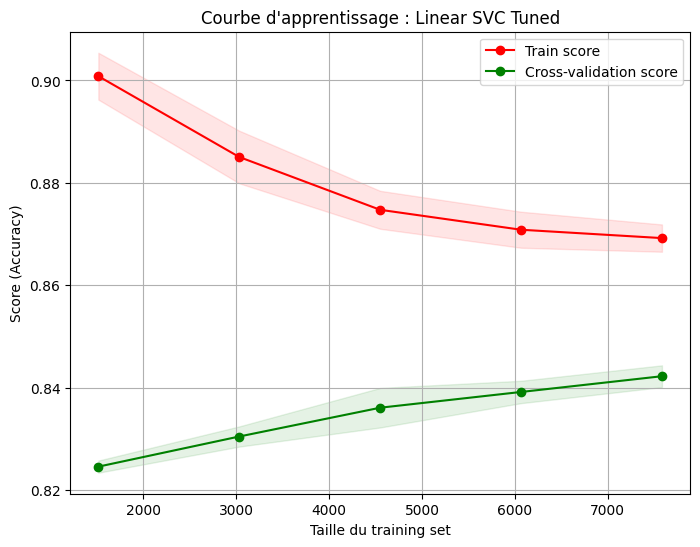

In [30]:
evaluate_model(best_svc_model, "Linear SVC Tuned", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train, n_classes)

In [31]:
save_model(best_svc_model, "Linear_SVC", "ML", "tuned")

- Sauvegarde du Modèle Linear_SVC
- Modèle Sauvegardé avec Succès sous : ../models/ML/linear_svc_tuned.pkl


<br>

<h5 style="font-weight:bold;">4.4. Random Forest :</h5>

<h3 style="color:yellow;text-align:center;font-weight:bold">Sans Grid-Search</h3>

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_model =  RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

rf_model = train_model(rf_model, X_train, y_train_encoded, "Random Forest")

- Entraînement du Modèle Random Forest
- Fin d'Entraînement !


Evaluation du Modèle Random Forest
- Accuracy Train : 0.9973
- Accuracy Test : 0.7813
- Gap Overfiting : 0.21598101265822778

- ROC AUC (OvR) : 0.9163

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.77      0.98      0.86      1805
     neutral       0.76      0.31      0.44       593
    positive       0.86      0.60      0.71       446

    accuracy                           0.78      2844
   macro avg       0.80      0.63      0.67      2844
weighted avg       0.78      0.78      0.75      2844


- Génération de la Matrice de Confusion...


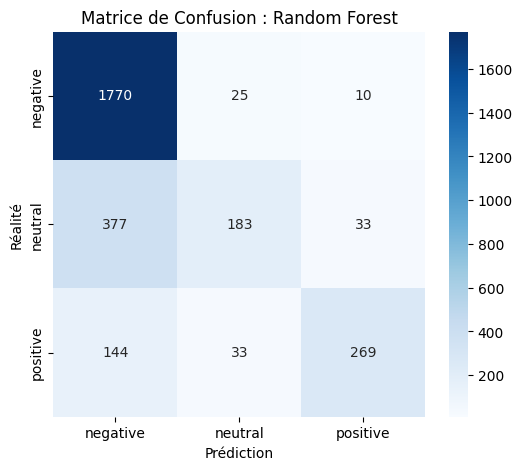


- Génération de la Courbe ROC...


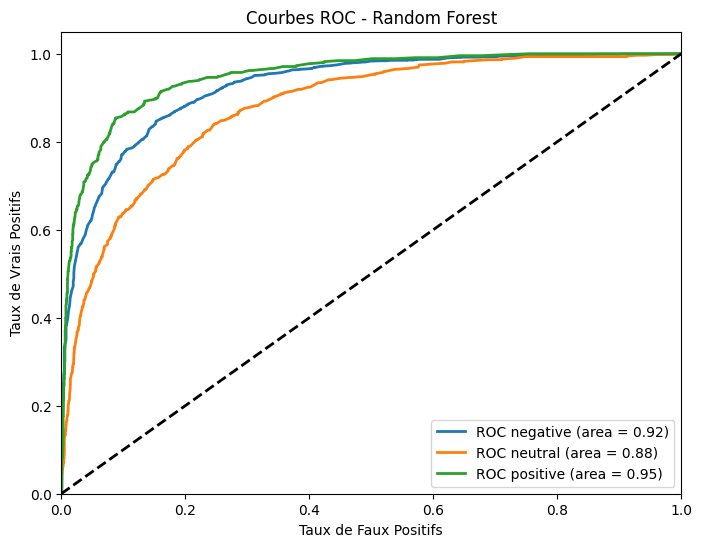


- Génération de la Courbe d'Apprentissage pour Random Forest...


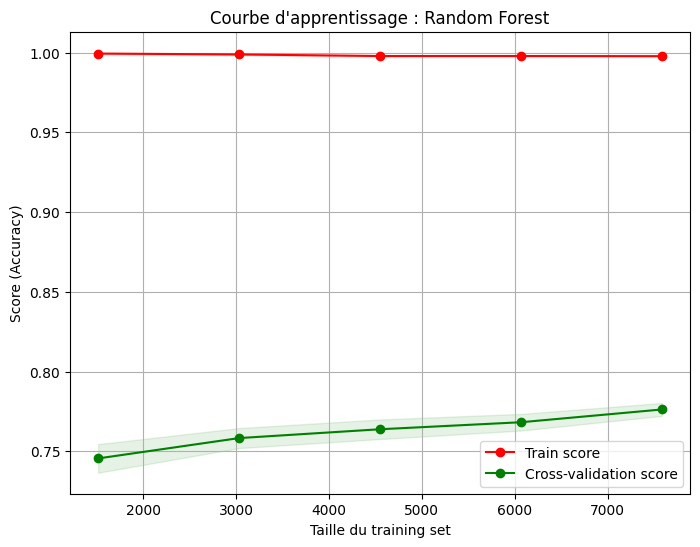

In [35]:
evaluate_model(rf_model, "Random Forest", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train, n_classes)

In [36]:
save_model(rf_model, "Random_Forest", "ML", "brut")

- Sauvegarde du Modèle Random_Forest
- Modèle Sauvegardé avec Succès sous : ../models/ML/random_forest_brut.pkl


<h4 style="color:orange;font-weight:bold;">5. Entraînement et Evaluation des Modèles DL :</h4>

<h3 style="color:yellow;text-align:center;font-weight:bold">MLP Classifier sans Grid-Search</h3>

In [79]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64), 
    activation='relu', 
    solver='adam', 
    alpha=0.0005, 
    batch_size='auto', 
    learning_rate='adaptive', 
    max_iter=1000, 
    early_stopping=True, 
    n_iter_no_change=20, 
    random_state=42
)

mlp_model = train_model(mlp_model, X_train_res, y_train_encoded, "MLP Classifier")

- Entraînement du Modèle MLP Classifier
- Fin d'Entraînement !


Evaluation du Modèle MLP Classifier
- Accuracy Train : 0.8721
- Accuracy Test : 0.8119
- Gap Overfiting : 0.060229827288630244

- ROC AUC (OvR) : 0.9266

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.92      0.85      0.88      1805
     neutral       0.60      0.72      0.65       593
    positive       0.74      0.79      0.76       446

    accuracy                           0.81      2844
   macro avg       0.75      0.79      0.77      2844
weighted avg       0.83      0.81      0.82      2844


- Génération de la Matrice de Confusion...


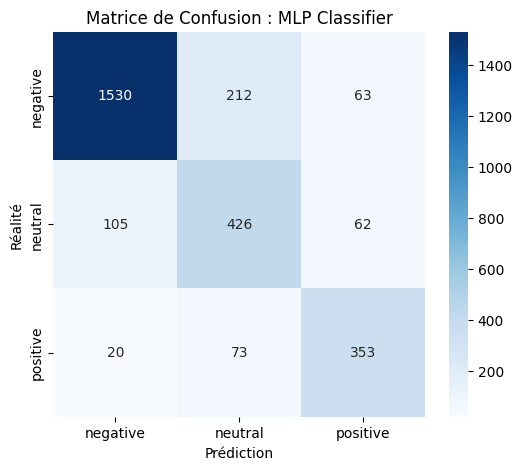


- Génération de la Courbe ROC...


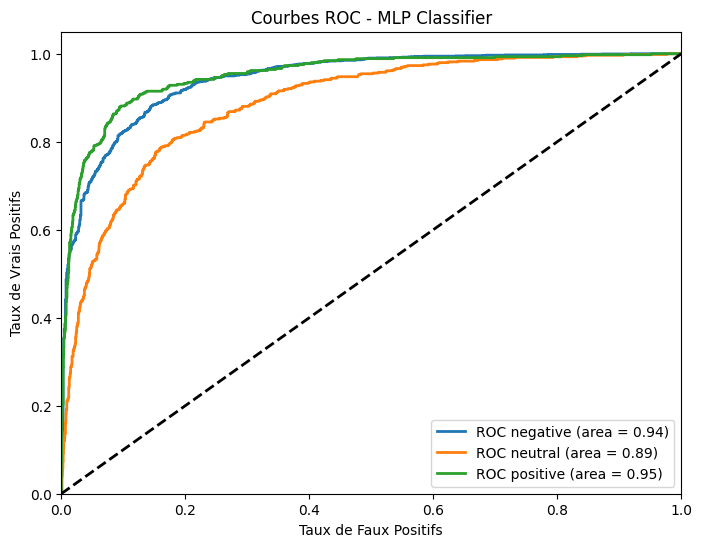


- Génération de la Courbe d'Apprentissage pour MLP Classifier...


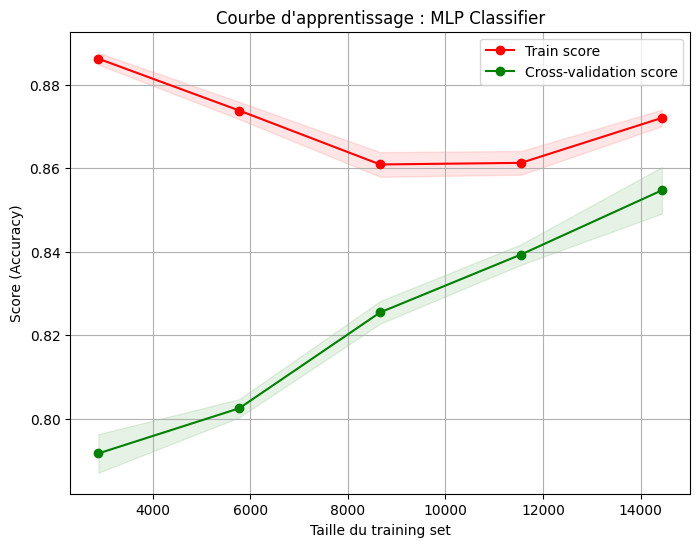

In [80]:
evaluate_model(svc_model, "MLP Classifier", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train_res, n_classes)

In [81]:
save_model(mlp_model, "MLP", "DL", "brut")

- Sauvegarde du Modèle MLP
- Modèle Sauvegardé avec Succès sous : ../models/DL/mlp_brut.pkl


<br>

<h3 style="color:yellow;text-align:center;font-weight:bold">MLP Classifier avec Grid-Search</h3>

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp_grid_model = MLPClassifier(
    solver='adam', 
    batch_size='auto',
    max_iter=1000, 
    early_stopping=True, 
    n_iter_no_change=20, 
    random_state=42
)

mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.0005, 0.001],
    'learning_rate_init': [0.001, 0.0005]
}

grid_search_mlp = GridSearchCV(
    estimator=mlp_grid_model,
    param_grid=mlp_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

mlp_grid_model = train_model(grid_search_mlp, X_train_res, y_train_encoded, "MLP Classifier Tuned")

best_mlp_model = mlp_grid_model.best_estimator_

print(f"Meilleurs Paramètres Trouvés : {mlp_grid_model.best_params_}")

- Entraînement du Modèle MLP Classifier Tuned
Fitting 3 folds for each of 36 candidates, totalling 108 fits
- Fin d'Entraînement !
Meilleurs Paramètres Trouvés : {'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.0005}


Evaluation du Modèle MLP Classifier Tuned
- Accuracy Train : 0.9910
- Accuracy Test : 0.8119
- Gap Overfiting : 0.1791125604372914

- ROC AUC (OvR) : 0.9189

- Rapport de Classification :
              precision    recall  f1-score   support

    negative       0.87      0.92      0.89      1805
     neutral       0.65      0.56      0.60       593
    positive       0.77      0.72      0.74       446

    accuracy                           0.81      2844
   macro avg       0.76      0.73      0.75      2844
weighted avg       0.81      0.81      0.81      2844


- Génération de la Matrice de Confusion...


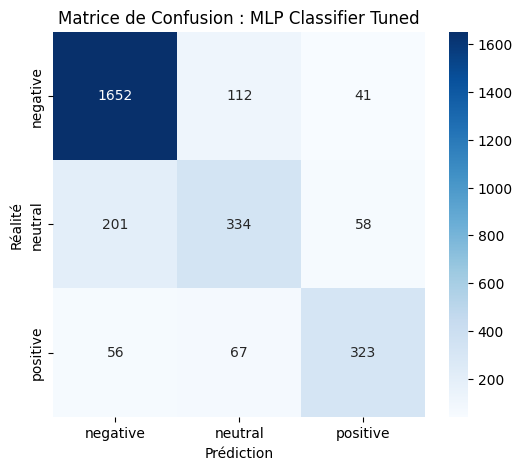


- Génération de la Courbe ROC...


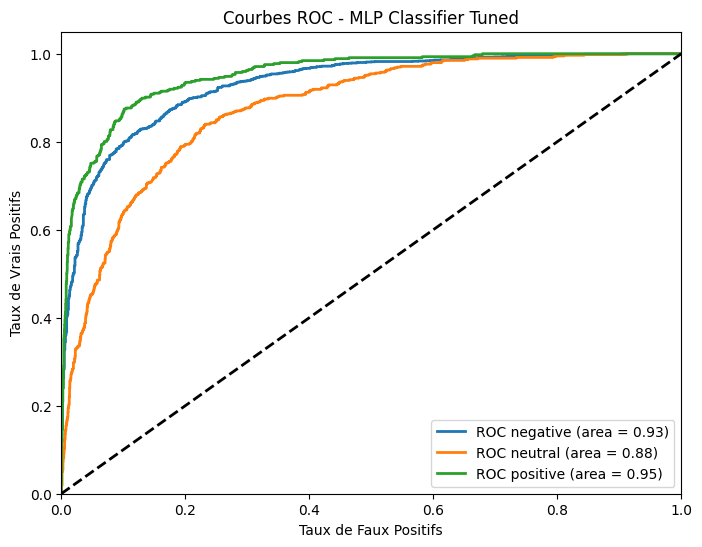


- Génération de la Courbe d'Apprentissage pour MLP Classifier Tuned...


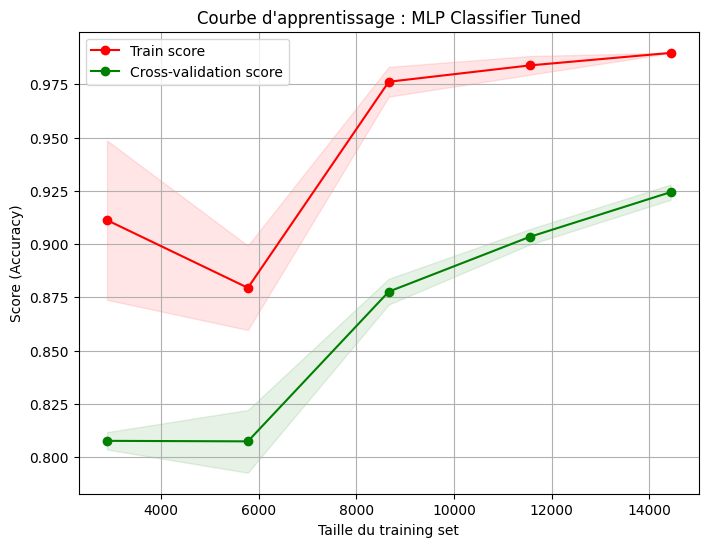

In [10]:
evaluate_model(best_mlp_model, "MLP Classifier Tuned", X_test, y_train_encoded, y_test_encoded, y_test_bin, target_names, X_train_res, n_classes)

In [11]:
save_model(best_mlp_model, "MLP", "DL", "tuned")

- Sauvegarde du Modèle MLP
- Modèle Sauvegardé avec Succès sous : ../models/DL/mlp_tuned.pkl
